### Challenge restrasos vuelos

In [56]:
%pwd
#'D:\\test\\flights\\src'

'D:\\test\\flights\\src'

In [57]:
import os

files = os.listdir('.')
print(files)
files = os.listdir('..')
print(files)
files = os.listdir('../data')
print(files)


['.ipynb_checkpoints', 'solution - Jhon Alexander Bernal.ipynb']
['.git', 'Challenge - Data Scientist.pdf', 'conf', 'Curriculum_Vitae_Alexander_Bernal.pdf', 'data', 'src']
['dataset_SCL.csv']


In [58]:
!pip install xgboost
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sklearn
import warnings
import graphviz

from sklearn.metrics import (auc,
                             accuracy_score,
                             confusion_matrix,
                             mean_squared_error)
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     KFold,
                                     RandomizedSearchCV,
                                     train_test_split)

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.compose import (ColumnTransformer,
                             make_column_transformer)
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline



In [60]:
sklearn.__version__

'1.1.1'

In [61]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))
    
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

            

# Tener los nombres de las características en un ColumnTransform de sklearn
def get_feature_names(column_transformer):
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    return feature_names

Se ha evaluado después de hacer el EDA que los datos vienen con un error de parseo en el campo de __Nombre ciudad destino__ que ha generado un reproceso que acontinueación se meustra como un cargue inicial y la dicivisón en dos conjunto uno cargado correctamente y el procesamiento de los datos equivocados reconstruyento la tabla como un dataframe válido y haciendo la unión de los dos dataframes para tener un archivo final consolidado.

In [62]:
dataset_SCL = pd.read_csv("../data/dataset_SCL.csv")


C:\Users\j9b3m7e8\AppData\Local\Temp\ipykernel_24452\1725007971.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_SCL = pd.read_csv("../data/dataset_SCL.csv")


In [63]:
dataset_SCL_1 = dataset_SCL[~dataset_SCL.DIA.isnull()]
dataset_SCL_1

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1.0,1.0,2017.0,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2.0,1.0,2017.0,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3.0,1.0,2017.0,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4.0,1.0,2017.0,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5.0,1.0,2017.0,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400.0,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22.0,12.0,2017.0,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400.0,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25.0,12.0,2017.0,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400.0,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27.0,12.0,2017.0,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400.0,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29.0,12.0,2017.0,Viernes,I,JetSmart SPA,Santiago,Lima


In [64]:
nulls_Rows = dataset_SCL[dataset_SCL.DIA.isnull()]["Fecha-I"].str.split(',', expand=True)
dataset_SCL_2 = nulls_Rows.drop(nulls_Rows.columns[[17, 18]],axis = 1)
dataset_SCL_2[17] = (nulls_Rows.iloc[:, 17] + nulls_Rows.iloc[:, 18])
dataset_SCL_2.columns = dataset_SCL_1.columns

dataset_SCL_2

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
17059,2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03-08 06:10:00,1351,SCEL,SBCT,LAN,8,3,2017,Miercoles,I,Grupo LATAM,Santiago,"""Curitiba Bra."""
17060,2017-03-06 14:20:00,1357,SCEL,SBCT,LAN,2017-03-06 14:26:00,1357,SCEL,SBCT,LAN,6,3,2017,Lunes,I,Grupo LATAM,Santiago,"""Curitiba Bra."""
39316,2017-08-10 20:15:00,8541,SCEL,SBCT,ONE,2017-08-10 20:11:00,8541,SCEL,SBCT,ONE,10,8,2017,Jueves,I,Oceanair Linhas Aereas,Santiago,"""Curitiba Bra."""
55332,2017-10-03 08:00:00,7896,SCEL,SANU,LAN,2017-10-03 08:00:00,7896,SCEL,SANU,DSM,3,10,2017,Martes,I,Grupo LATAM,Santiago,"""San Juan Arg."""
55333,2017-10-05 08:00:00,7896,SCEL,SANU,LAN,2017-10-05 07:59:00,7896,SCEL,SANU,DSM,5,10,2017,Jueves,I,Grupo LATAM,Santiago,"""San Juan Arg."""
55334,2017-10-06 08:10:00,7896,SCEL,SANU,LAN,2017-10-06 08:23:00,7896,SCEL,SANU,DSM,6,10,2017,Viernes,I,Grupo LATAM,Santiago,"""San Juan Arg."""
55335,2017-10-12 08:00:00,7896,SCEL,SANU,LAN,2017-10-12 08:04:00,7896,SCEL,SANU,DSM,12,10,2017,Jueves,I,Grupo LATAM,Santiago,"""San Juan Arg."""
55336,2017-10-13 08:10:00,7896,SCEL,SANU,LAN,2017-10-13 08:27:00,7896,SCEL,SANU,DSM,13,10,2017,Viernes,I,Grupo LATAM,Santiago,"""San Juan Arg."""
55337,2017-10-17 08:00:00,7896,SCEL,SANU,LAN,2017-10-17 08:11:00,7896,SCEL,SANU,DSM,17,10,2017,Martes,I,Grupo LATAM,Santiago,"""San Juan Arg."""
55338,2017-10-20 08:10:00,7896,SCEL,SANU,LAN,2017-10-20 08:32:00,7896,SCEL,SANU,DSM,20,10,2017,Viernes,I,Grupo LATAM,Santiago,"""San Juan Arg."""


In [65]:
dataset_SCL = dataset_SCL_1.append(dataset_SCL_2, ignore_index=True)

C:\Users\j9b3m7e8\AppData\Local\Temp\ipykernel_24452\2588337095.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_SCL = dataset_SCL_1.append(dataset_SCL_2, ignore_index=True)


In [66]:
dataset_SCL[dataset_SCL.DIA.isnull()].index

Int64Index([], dtype='int64')

In [67]:
dataset_SCL.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1.0,1.0,2017.0,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2.0,1.0,2017.0,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3.0,1.0,2017.0,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4.0,1.0,2017.0,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5.0,1.0,2017.0,Jueves,I,American Airlines,Santiago,Miami


In [68]:
dataset_SCL['Fecha-I'] = pd.to_datetime(dataset_SCL['Fecha-I'], format='%Y-%m-%d %H:%M')
dataset_SCL['Fecha-O'] = pd.to_datetime(dataset_SCL['Fecha-O'], format='%Y-%m-%d %H:%M')


In [69]:
dataset_SCL["AÑO"] = dataset_SCL['Fecha-I'].dt.year.astype(int)
dataset_SCL["MES"] = dataset_SCL['Fecha-I'].dt.month.astype(int)
dataset_SCL["DIA"] = dataset_SCL['Fecha-I'].dt.day.astype(int)
dataset_SCL['Fecha_sint'] = pd.to_datetime(dict(year=dataset_SCL['AÑO'], month=dataset_SCL.MES, day=dataset_SCL.DIA))

### EDA

In [70]:
random_seed = 42

**Fecha-I** : Fecha y hora programada del vuelo.  
**Vlo-I** : Número de vuelo programado.  
**Ori-I** : Código de ciudad de origen programado.  
**Des-I** : Código de ciudad de destino programado.  
**Emp-I** : Código aerolínea de vuelo programado.  
**Fecha-O** : Fecha y hora de operación del vuelo.  
**Vlo-O** : Número de vuelo de operación del vuelo.  
**Ori-O** : Código de ciudad de origen de operación.  
**Des-O** : Código de ciudad de destino de operación.  
**Emp-O** : Código aerolínea de vuelo operado.  
**DIA** : Día del mes de operación del vuelo.  
**MES** : Número de mes de operación del vuelo.  
**AÑO** : Año de operación del vuelo.  
**DIANOM** : Día de la semana de operación del vuelo.  
**TIPOVUELO** : Tipo de vuelo, I =Internacional, N =Nacional.  
**OPERA** : Nombre de aerolínea que opera.  
**SIGLAORI** : Nombre ciudad origen.  
**SIGLADES** : Nombre ciudad destino.  

In [71]:
print(type(dataset_SCL["Fecha-I"][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Deseo ver problemas de estacionalidad para el posterior modelamiento por eso intento graficar la serie de tiempo de cada tipo de vuelo, la cantidad de vuelos por día.

In [72]:
day_set_data = dataset_SCL.groupby(["Fecha_sint","TIPOVUELO"]).agg({"Vlo-I":"nunique"}).reset_index().\
sort_values(by=["Fecha_sint"]).set_index("Fecha_sint")


day_set_data_w =pd.pivot(day_set_data, columns = "TIPOVUELO",values = "Vlo-I") 
day_set_data_w

TIPOVUELO,I,N
Fecha_sint,,
2017-01-01,81,87
2017-01-02,87,100
2017-01-03,90,96
2017-01-04,91,93
2017-01-05,86,103
...,...,...
2017-12-27,91,113
2017-12-28,90,113
2017-12-29,92,116


matplotlib.axes._subplots.AxesSubplot

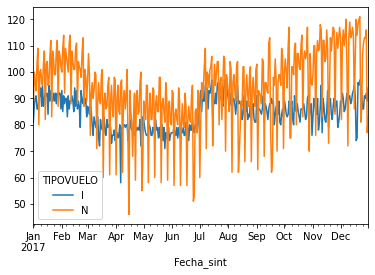

In [73]:
axes = day_set_data_w.plot.line()
type(axes)

Deseo ver problemas de estacionalidad para el posterior modelamiento por eso intento graficar la serie de tiempo de cada tipo de vuelo, la cantidad de vuelos por mes.

In [74]:
month_set_data = dataset_SCL.groupby(["AÑO", "MES","TIPOVUELO"]).agg({"Vlo-I":"nunique"}).reset_index().\
sort_values(by=["TIPOVUELO"]).set_index(["AÑO","MES"])


month_set_data_w =pd.pivot(month_set_data, columns = "TIPOVUELO",values = 'Vlo-I') 
month_set_data_w


TIPOVUELO    I    N
AÑO  MES           
2017 1     141  170
     2     123  160
     3     136  160
     4     123  160
     5     115  158
     6     116  144
     7     153  174
     8     123  166
     9     125  174
     10    138  204
     11    133  203
     12    145  225

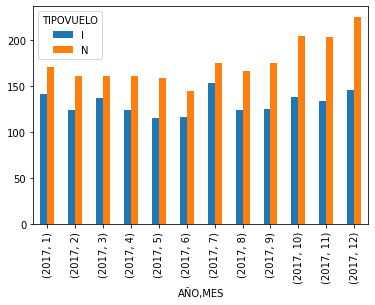

In [75]:
ax = month_set_data_w.plot.bar()

### Features set 1  
* temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.

In [76]:
data = dataset_SCL.copy()

In [77]:
data["temporada_alta"] =  pd.Series(np.where(
    (data['Fecha_sint'] >= "2017-01-01") & (data['Fecha_sint'] <= "2017-03-03") |\
    (data['Fecha_sint'] >= "2017-12-15") & (data['Fecha_sint'] <= "2017-01-01") |\
    (data['Fecha_sint'] >= "2017-07-15") & (data['Fecha_sint'] <= "2017-07-31") |\
    (data['Fecha_sint'] >= "2017-09-11") & (data['Fecha_sint'] <= "2017-07-31"), 1, 0))

In [78]:
data["temporada_alta"].value_counts()

0    52670
1    15536
Name: temporada_alta, dtype: int64

* dif_min : diferencia en minutos entre Fecha-O y Fecha-I.  
* atraso_15 : 1 si dif_min > 15, 0 si no.

In [79]:
data["dif_min"] = (data["Fecha-O"]-data["Fecha-I"]).astype('timedelta64[m]')
data["atraso_15"] = pd.Series(np.where(
    (data['dif_min'] >= 15) , 1, 0))

* periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I .

In [80]:
data["periodo_dia"] = pd.Series(np.where(
    (data["Fecha-I"].dt.hour.astype(int) >= 5) &  (data["Fecha-I"].dt.hour.astype(int) < 12), "mañana",
    np.where((data["Fecha-I"].dt.hour.astype(int) >= 12) &  (data["Fecha-I"].dt.hour.astype(int) < 19), "tarde",
    "noche")))

In [81]:
data.groupby(["periodo_dia", data["Fecha-I"].dt.hour.astype(int)]).agg({"Vlo-I":"nunique"}).reset_index().sort_values(by=["Fecha-I"])

,periodo_dia,Fecha-I,Vlo-I
7,noche,0,37
8,noche,1,28
9,noche,2,26
10,noche,3,27
11,noche,4,48
0,mañana,5,76
1,mañana,6,103
2,mañana,7,141
3,mañana,8,149
4,mañana,9,124


### Guardar las nuevas características

In [82]:
data.to_csv('../data/synthetic_features.csv')

¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?

In [83]:
opera_retraso = pd.pivot(data.groupby(["atraso_15", "OPERA"]).agg({"Vlo-I":"nunique"}).reset_index().set_index(["OPERA"])\
                         ,columns = "atraso_15",values = 'Vlo-I') .\
sort_values(by = [1])

opera_retraso["total"] = opera_retraso[0]+opera_retraso[1]
opera_retraso["por_ret"] = 100*opera_retraso[1]/opera_retraso["total"]
opera_retraso["sin"] = 100*opera_retraso[0]/sum(opera_retraso[0])
opera_retraso["con"] = 100*opera_retraso[1]/sum(opera_retraso[1])
opera_retraso = opera_retraso.sort_values(by = ["con"])

In [84]:
opera_retraso

atraso_15,0,1,total,por_ret,sin,con
OPERA,,,,,,
United Airlines,2,1,3,33.333333,0.258398,0.142248
Air France,1,1,2,50.000000,0.129199,0.142248
Alitalia,1,1,2,50.000000,0.129199,0.142248
British Airways,1,1,2,50.000000,0.129199,0.142248
Qantas Airways,1,1,2,50.000000,0.129199,0.142248
Delta Air,1,1,2,50.000000,0.129199,0.142248
Iberia,1,1,2,50.000000,0.129199,0.142248
Lacsa,2,1,3,33.333333,0.258398,0.142248
K.L.M.,1,1,2,50.000000,0.129199,0.142248


En la tabla anterior se observa cómo el Grupo LATAM es la aerolínea con mayor cantidad de retrasos, acumulando el 66.9% de todos los vuleos con retrasos superiores a 15 minutos. Sin embargo, en la sigueitne tabla es puede observar que se encuentra en el top 6 de las aerolíneas con mejor relación entre vuelos con retraso dados los vuelos totales operados, con un 46.9% de vuelos operado que tuvieron restraso de mas de 15 minutos.

In [85]:
opera_retraso.sort_values(by = ["por_ret"])

atraso_15,0,1,total,por_ret,sin,con
OPERA,,,,,,
United Airlines,2,1,3,33.333333,0.258398,0.142248
Air Canada,4,2,6,33.333333,0.516796,0.284495
Lacsa,2,1,3,33.333333,0.258398,0.142248
Gol Trans,14,10,24,41.666667,1.808786,1.422475
American Airlines,5,4,9,44.444444,0.645995,0.568990
Grupo LATAM,533,471,1004,46.912351,68.863049,66.998578
JetSmart SPA,43,38,81,46.913580,5.555556,5.405405
Sky Airline,98,92,190,48.421053,12.661499,13.086771
Iberia,1,1,2,50.000000,0.129199,0.142248


In [86]:
tipo_retraso = pd.pivot(data.groupby(["atraso_15", "TIPOVUELO", "DIANOM"]).agg({"Vlo-I":"nunique"}).reset_index().set_index(["DIANOM","TIPOVUELO"])\
                         ,columns = "atraso_15",values = 'Vlo-I') .\
fillna(0).\
sort_values(by = [1])
tipo_retraso
tipo_retraso["total"] = tipo_retraso[0]+tipo_retraso[1]
tipo_retraso["por_ret"] = 100*tipo_retraso[1]/tipo_retraso["total"]
tipo_retraso["sin"] = 100*tipo_retraso[0]/sum(tipo_retraso[0])
tipo_retraso["con"] = 100*tipo_retraso[1]/sum(tipo_retraso[1])
tipo_retraso = tipo_retraso.sort_values(by = ["por_ret"])

In [87]:
tipo_retraso

atraso_15              0    1  total    por_ret       sin       con
DIANOM    TIPOVUELO                                                
Miercoles N          234  173    407  42.506143  7.627119  6.728899
Sabado    N          217  163    380  42.894737  7.073012  6.339946
Martes    N          225  173    398  43.467337  7.333768  6.728899
Domingo   N          234  181    415  43.614458  7.627119  7.040062
Lunes     N          228  189    417  45.323741  7.431551  7.351225
          I          204  172    376  45.744681  6.649283  6.690004
Martes    I          199  168    367  45.776567  6.486310  6.534422
Jueves    N          250  214    464  46.120690  8.148631  8.323609
Viernes   N          247  212    459  46.187364  8.050847  8.245819
Sabado    I          217  188    405  46.419753  7.073012  7.312330
Domingo   I          215  191    406  47.044335  7.007823  7.429016
Miercoles I          201  182    383  47.519582  6.551499  7.078958
Jueves    I          195  179    374  47.860963  6.355932  6.962271
Viernes   I          202  186    388  47.938144  6.584094  7.234539

Los días con mayor numero de restrasos con los jueves y viernes en vuelos de destino nacional en estos días se tienen retrasos en el 46% de los vuelos y tienen el 8% del total de cuelos con restraso.

In [88]:
retraso = pd.pivot(data.groupby(["atraso_15", "OPERA", "SIGLADES", "MES", "DIANOM", "temporada_alta", "TIPOVUELO"]).\
                   agg({"Vlo-I":"nunique"}).reset_index().set_index(["OPERA", "SIGLADES", "MES", "DIANOM", "temporada_alta", "TIPOVUELO"])\
                         ,columns = "atraso_15",values = 'Vlo-I') .\
fillna(0).\
sort_values(by = [1])
retraso
retraso["total"] = retraso[0]+retraso[1]
retraso["por_ret"] = 100*retraso[1]/retraso["total"]
retraso["sin"] = 100*retraso[0]/sum(retraso[0])
retraso["con"] = 100*retraso[1]/sum(retraso[1])
retraso = retraso.sort_values(by = ["con"])

In [89]:
retraso

atraso_15                                                            0     1  \
OPERA           SIGLADES    MES DIANOM  temporada_alta TIPOVUELO               
United Airlines Washington  8   Martes  0              I           1.0   0.0   
                Houston     3   Jueves  1              I           1.0   0.0   
                                        0              I           1.0   0.0   
                                Domingo 0              I           1.0   0.0   
Grupo LATAM     Madrid      3   Jueves  1              I           2.0   0.0   
...                                                                ...   ...   
                Antofagasta 7   Lunes   1              N          13.0  11.0   
                                Martes  1              N           6.0  12.0   
                            10  Jueves  0              N          15.0  12.0   
                                Viernes 0              N          14.0  13.0   
                            11  Lunes   0              N          13.0  13.0   

atraso_15                                                         total  \
OPERA           SIGLADES    MES DIANOM  temporada_alta TIPOVUELO          
United Airlines Washington  8   Martes  0              I            1.0   
                Houston     3   Jueves  1              I            1.0   
                                        0              I            1.0   
                                Domingo 0              I            1.0   
Grupo LATAM     Madrid      3   Jueves  1              I            2.0   
...                                                                 ...   
                Antofagasta 7   Lunes   1              N           24.0   
                                Martes  1              N           18.0   
                            10  Jueves  0              N           27.0   
                                Viernes 0              N           27.0   
                            11  Lunes   0              N           26.0   

atraso_15                                                           por_ret  \
OPERA           SIGLADES    MES DIANOM  temporada_alta TIPOVUELO              
United Airlines Washington  8   Martes  0              I           0.000000   
                Houston     3   Jueves  1              I           0.000000   
                                        0              I           0.000000   
                                Domingo 0              I           0.000000   
Grupo LATAM     Madrid      3   Jueves  1              I           0.000000   
...                                                                     ...   
                Antofagasta 7   Lunes   1              N          45.833333   
                                Martes  1              N          66.666667   
                            10  Jueves  0              N          44.444444   
                                Viernes 0              N          48.148148   
                            11  Lunes   0              N          50.000000   

atraso_15                                                              sin  \
OPERA           SIGLADES    MES DIANOM  temporada_alta TIPOVUELO             
United Airlines Washington  8   Martes  0              I          0.005344   
                Houston     3   Jueves  1              I          0.005344   
                                        0              I          0.005344   
                                Domingo 0              I          0.005344   
Grupo LATAM     Madrid      3   Jueves  1              I          0.010689   
...                                                                    ...   
                Antofagasta 7   Lunes   1              N          0.069478   
                                Martes  1              N          0.032067   
                            10  Jueves  0              N          0.080167   
                                Viernes 0              N          0.074822   
                   

En este momento luego de explorar las relaciones entre variables y el analisis adicional de composición de los vuelos con retraso por las diferentes aperturas de operados, destino, mes, dia, temporada y tipo vuelo, es de esperar que el operador, el tipo de vuelo, el día, la temporada_alta y el periodo del día resuelvan de forma eficiente el caso del pronóstico de la probabilidad de restraso de un vuelo.

### Modelamiento

Se procede con la codificación de las variables categoricas mediante el transformer de OHE one-hot encoding

In [90]:
data_full = data.set_index(["Fecha-I","Vlo-I"])[["OPERA", "SIGLADES", "MES", "DIANOM", #"dif_min",
                                                 "temporada_alta", "TIPOVUELO", "periodo_dia",
                                                 "atraso_15"]]
X = data_full.iloc[:,0:7]
y = data_full.iloc[:,7]

In [91]:
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object', 'bool']).columns.tolist()

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

categorical_transformer = OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=0.1)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean"))]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ], remainder='passthrough'
)

transformed_train = preprocessor.fit_transform(X_train)
X_train_skl_ohe = pd.DataFrame(transformed_train, columns = get_feature_names(preprocessor))
# transformed_train
X_train_skl_ohe.columns = X_train_skl_ohe.columns.str.lstrip("num__")
X_train_skl_ohe.columns = X_train_skl_ohe.columns.str.replace("x0_infrequent_sklearn", "other_oper")
X_train_skl_ohe.columns = X_train_skl_ohe.columns.str.replace("x1_infrequent_sklearn", "destino")
X_train_skl_ohe.columns = X_train_skl_ohe.columns.str.lstrip("cat__x0_")
X_train_skl_ohe.columns = X_train_skl_ohe.columns.str.lstrip("cat__x1_")
X_train_skl_ohe.columns = X_train_skl_ohe.columns.str.lstrip("cat__x2_")
X_train_skl_ohe.columns = X_train_skl_ohe.columns.str.lstrip("cat__x3_")
X_train_skl_ohe.columns = X_train_skl_ohe.columns.str.lstrip("cat__x4_")


C:\Users\j9b3m7e8\AppData\Local\Temp\ipykernel_24452\2097863996.py:41: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
C:\Users\j9b3m7e8\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [92]:
X_train_skl_ohe

,MES,emporada_alta,Grupo LATAM,Sky Airline,other_oper,destino,Domingo,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes,I,N,mañana,noche,rde
0,11.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,10.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,6.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51149,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
51150,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
51151,10.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
51152,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [93]:
y.value_counts()

0    54590
1    13616
Name: atraso_15, dtype: int64

In [94]:
transformed_test = preprocessor.fit_transform(X_test)
X_test_skl_ohe = pd.DataFrame(transformed_test, columns = get_feature_names(preprocessor))
# transformed_test
X_test_skl_ohe.columns = X_test_skl_ohe.columns.str.lstrip("num__")
X_test_skl_ohe.columns = X_test_skl_ohe.columns.str.replace("x0_infrequent_sklearn", "other_oper")
X_test_skl_ohe.columns = X_test_skl_ohe.columns.str.replace("x1_infrequent_sklearn", "destino")
X_test_skl_ohe.columns = X_test_skl_ohe.columns.str.lstrip("cat__x0_")
X_test_skl_ohe.columns = X_test_skl_ohe.columns.str.lstrip("cat__x1_")
X_test_skl_ohe.columns = X_test_skl_ohe.columns.str.lstrip("cat__x2_")
X_test_skl_ohe.columns = X_test_skl_ohe.columns.str.lstrip("cat__x3_")
X_test_skl_ohe.columns = X_test_skl_ohe.columns.str.lstrip("cat__x4_")
X_test_skl_ohe

C:\Users\j9b3m7e8\AppData\Local\Temp\ipykernel_24452\2097863996.py:41: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
C:\Users\j9b3m7e8\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,MES,emporada_alta,Grupo LATAM,Sky Airline,other_oper,destino,Domingo,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes,I,N,mañana,noche,rde
0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,11.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17047,11.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
17048,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
17049,11.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
17050,8.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


Ajustar un modelo base para evaluar desempeño

In [95]:
# fit model no training data
neg_pos = y_train.value_counts()[0]/y_train.value_counts()[1]
model = xgb.XGBClassifier(scale_pos_weight=neg_pos, max_depth= 6)
model.fit(X_train_skl_ohe, y_train)
# make predictions for test data
y_pred = model.predict(X_test_skl_ohe)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)
print(100*cf_matrix/np.sum(cf_matrix))

Accuracy: 61.32%
[[8391 5300]
 [1296 2065]]
[[49.20830401 31.08139808]
 [ 7.60028149 12.11001642]]


<AxesSubplot:>

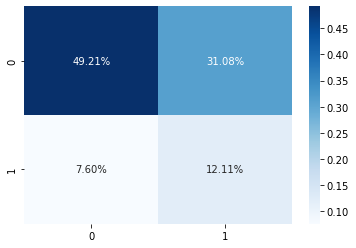

In [96]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

El modelo base genera una tasa de clasificación del **61.32%** pero al evaluar la matriz de confución se puede ver que el desbalance de los datos afacta notablemente el desempeño

In [97]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42,
                              eval_metric="error", scale_pos_weight=neg_pos, max_depth= 6)

xgb_model.fit(X_train_skl_ohe, y_train, early_stopping_rounds=45, eval_set=[(X_test_skl_ohe, y_test)])

y_pred = xgb_model.predict(X_test_skl_ohe)

accuracy_score(y_test, y_pred)

[0]	validation_0-error:0.41954
[1]	validation_0-error:0.41913
[2]	validation_0-error:0.40646
[3]	validation_0-error:0.40359
[4]	validation_0-error:0.40506
[5]	validation_0-error:0.40294
[6]	validation_0-error:0.40001


C:\Users\j9b3m7e8\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-error:0.39925
[8]	validation_0-error:0.39426
[9]	validation_0-error:0.39608
[10]	validation_0-error:0.39333
[11]	validation_0-error:0.39034
[12]	validation_0-error:0.38846
[13]	validation_0-error:0.38781
[14]	validation_0-error:0.38916
[15]	validation_0-error:0.38858
[16]	validation_0-error:0.39045
[17]	validation_0-error:0.38758
[18]	validation_0-error:0.38834
[19]	validation_0-error:0.38693
[20]	validation_0-error:0.38934
[21]	validation_0-error:0.39034
[22]	validation_0-error:0.38852
[23]	validation_0-error:0.38740
[24]	validation_0-error:0.38934
[25]	validation_0-error:0.38852
[26]	validation_0-error:0.38688
[27]	validation_0-error:0.38576
[28]	validation_0-error:0.38576
[29]	validation_0-error:0.38412
[30]	validation_0-error:0.38652
[31]	validation_0-error:0.38734
[32]	validation_0-error:0.38746
[33]	validation_0-error:0.38899
[34]	validation_0-error:0.38822
[35]	validation_0-error:0.38822
[36]	validation_0-error:0.38746
[37]	validation_0-error:0.38846
[38]	valida

0.6175228712174525

In [98]:
print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

best score: 0.3824771287825475, best iteration: 77, best ntree limit 78


Tasa de error de clasificación binaria. Se calcula como #(casos incorrectos)/#(todos los casos). El modelo con early sttoping encuentra un modelo que pronostica una tasa de error del 38% con lo que aún no se logra mejorar el desempeño del modelo.

En la siguietne imagen se puede ver la importancia de las variables introducidas al modelo, el mes tiene la mayor importancia, loq ue encaja con el analisis exploratorio, al igual que la varaible que denota los vuelos internacionales.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

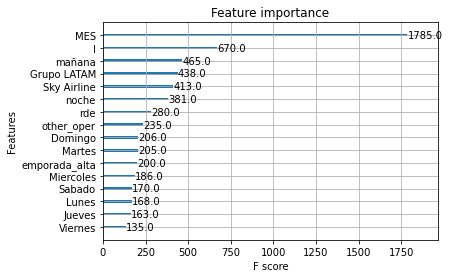

In [99]:
xgb.plot_importance(xgb_model)

Accuracy: 61.75%
[[8456 5235]
 [1287 2074]]
[[0.49589491 0.30700211]
 [0.07547502 0.12162796]]


<AxesSubplot:>

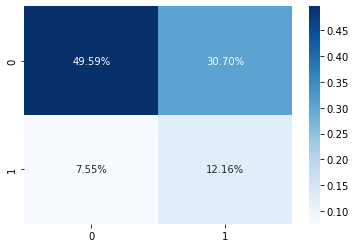

In [100]:
y_pred = xgb_model.predict(X_test_skl_ohe)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)
print(cf_matrix/np.sum(cf_matrix))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')